<a href="https://colab.research.google.com/github/Carlos-Muniz/United-States-Plants-Clustering/blob/master/plant_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# United States Plants
* **Problem**: United States Plant location by state - Clustering
* **Dataset**: [Plant Data Set](https://archive.ics.uci.edu/ml/machine-learning-databases/plants/)
* **Methods**: A  Variety of Clustering Algorithms
* **Evaluation**:

## Contents
1. Import Libraries
2. Load Dataset
3. Exploratory Data Analysis
4. Clustering
5. Evaluation

# Import Libraries

In [ ]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 73.1 kB of archives.
After this operation, 486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Fetched 73.1 kB in 2s (47.3 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 144803 files and directories currently installed.)
Pr

     |████████████████████████████████| 2.8MB 2.8MB/s 
  Created wheel for pyproj: filename=pyproj-1.9.6-cp36-cp36m-linux_x86_64.whl size=3702110 sha256=51fca1c66a1e364806b1b9dffdd7b7180e5c40e459d869f2f97b3c2d60ac6e83
  Stored in directory: /root/.cache/pip/wheels/02/cd/b1/a2d6430f74c7a778a43d62f78bec109ca69c732dc9b929142a
Successfully built pyproj
  Found existing installation: pyproj 2.6.1.post1
    Uninstalling pyproj-2.6.1.post1:
      Successfully uninstalled pyproj-2.6.1.post1


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.0/spark-3.0.0-bin-hadoop2.7.tgz
!tar xf spark-3.0.0-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init("spark-3.0.0-bin-hadoop2.7")# SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import pyspark.sql.types as st
from mpl_toolkits.basemap import Basemap

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Dataset

In [ ]:
with open('plants.data', 'r', encoding='cp1252') as fin:
    data = fin.read().splitlines()

with open('stateabbr.txt', 'r', encoding='cp1252') as fin:
    states = fin.read().splitlines()

In [ ]:
statesDict = {}
statesVector = {}
for i, s in enumerate(states[3:56]):
    stateSplit = s.split()
    abbreviation = stateSplit[0]
    stateName = " ".join(stateSplit[1:])
    statesDict[abbreviation] = stateName
    statesVector[abbreviation] = i

In [ ]:
cols = [' '] * (len(statesVector) + 1)
cols[0] = 'plant'

for k, v in statesVector.items():
    cols[v+1] = k
cleanData = []
for d in data:
    splitData = d.split(',')
    row = [splitData[0]]
    row.extend([0]*len(statesVector))
    for s in splitData[1:]:
        if s in statesVector:
            row[statesVector[s] + 1] = 1
    cleanData.append(row)
cols[1] = 'al'

In [ ]:
schemaCols = [st.StructField(c, st.IntegerType(), True) for c in cols[1:]]
schemaCols.insert(0,st.StructField(cols[0], st.StringType(), True))
dfSchema = st.StructType(schemaCols)
df = spark.createDataFrame(cleanData, dfSchema)
df.show(3)

+--------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|               plant| al| ak| ar| az| ca| co| ct| de| dc| fl| ga| hi| id| il| in| ia| ks| ky| la| me| md| ma| mi| mn| ms| mo| mt| ne| nv| nh| nj| nm| ny| nc| nd| oh| ok| or| pa| pr| ri| sc| sd| tn| tx| ut| vt| va| vi| wa| wv| wi| wy|
+--------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|              abelia|  0|  0|  0|  0|  0|  0|  0|  0|  0|  1|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  1|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|
|abelia x grandiflora|  0|  0|  0|  0|  0|  0|  0|  0|  0|  

In [ ]:
url = "https://gist.githubusercontent.com/sjengle/5315515/raw/2c636f8e0d3008529a1a0b66a9b2b93acde6d1b1/us-capitals.csv"
stateLocs = pd.read_csv(url, index_col='id')
stateLocs.head()

,abbrev,state,capital,latitude,longitude,population
id,,,,,,
1,AL,Alabama,Montgomery,32.380120,-86.300629,205764
2,AK,Alaska,Juneau,58.299740,-134.406794,31275
4,AZ,Arizona,Phoenix,33.448260,-112.075774,1445632
5,AR,Arkansas,Little Rock,34.748655,-92.274494,193524
6,CA,California,Sacramento,38.579065,-121.491014,466488


In [ ]:
long_lats = stateLocs.set_index('abbrev')[['latitude', 'longitude']].to_dict('index')
long_lats['DC'] = {'latitude': 38.8964, 'longitude': -77.0262}
long_lats['PR'] = {'latitude': 18.4683333, 'longitude': -66.1061111}
long_lats['VI'] = {'latitude': 18.35, 'longitude': -64.95}

# Exploratory Data Analysis

In [ ]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = cols[1:], outputCol = 'features')
dfVectors = vectorAssembler.transform(df).select("plant", "features")

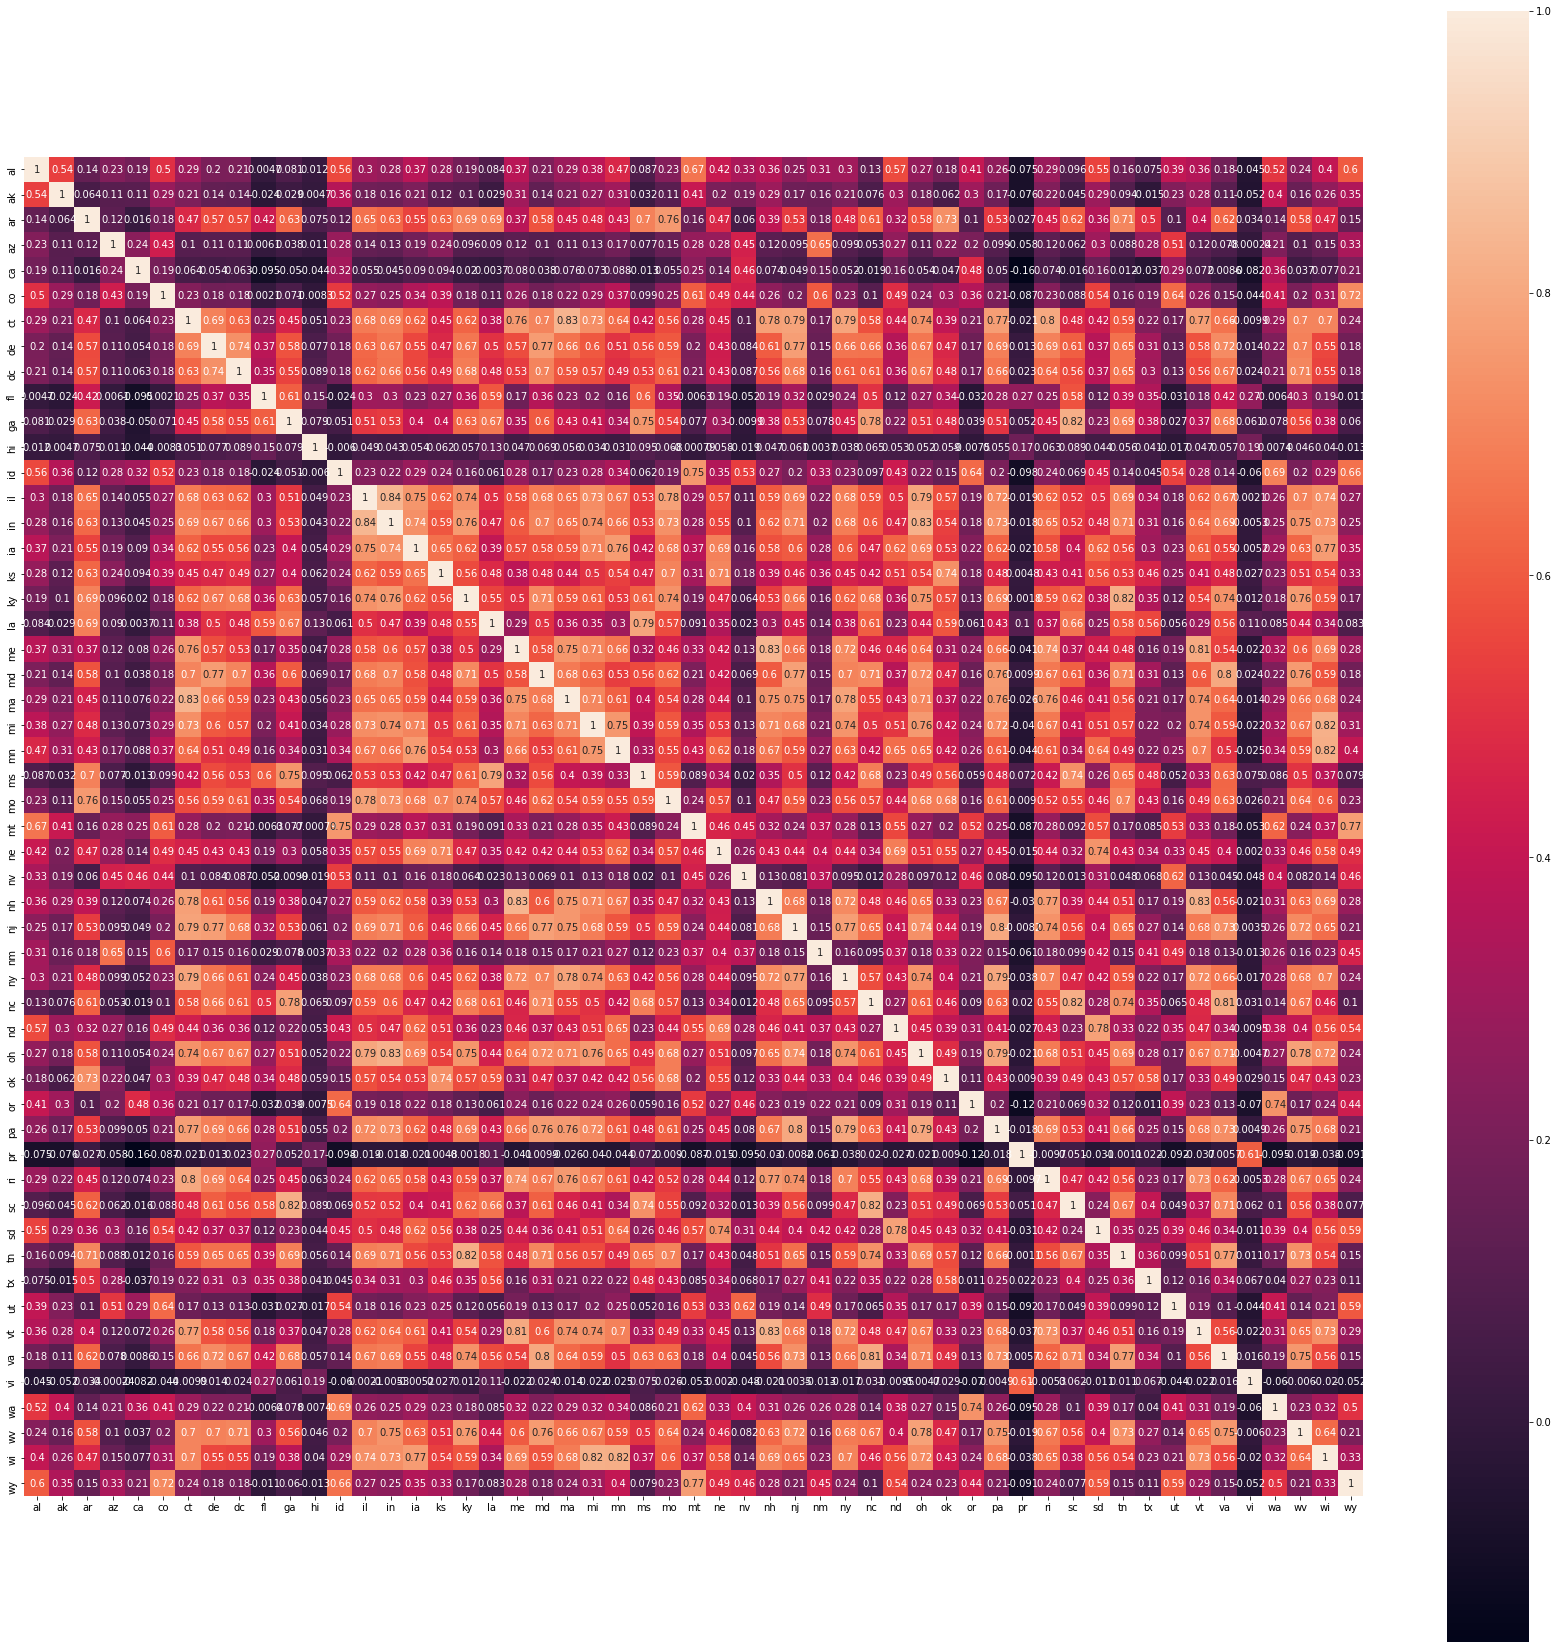

In [ ]:
from pyspark.ml.stat import Correlation
matrix = Correlation.corr(dfVectors, "features").collect()[0][0]
corrmatrix = matrix.toArray()
fig = plt.figure(figsize=(30,30))
sns.heatmap(corrmatrix, annot=True, square=True, xticklabels=cols[1:], yticklabels=cols[1:])

In [ ]:
n = len(cols[1:])
rankedCorrelations = []
for i in range(n):
    for j in range(i+1, n):
        rankedCorrelations.append(
            [corrmatrix[i,j], (cols[i+1], cols[j+1])])
rankedCorrelations.sort(reverse=True)
rankedCorrelations[:20]

[[0.8416817810739237, ('il', 'in')],
 [0.8346939788977901, ('ct', 'ma')],
 [0.8339142726317565, ('me', 'nh')],
 [0.8272011180780274, ('nh', 'vt')],
 [0.8253229725324557, ('in', 'oh')],
 [0.8205156260376496, ('mi', 'wi')],
 [0.8192475897647328, ('ky', 'tn')],
 [0.8192056644342194, ('ga', 'sc')],
 [0.8164128222927273, ('mn', 'wi')],
 [0.8161859871671291, ('nc', 'sc')],
 [0.8078850116192068, ('nc', 'va')],
 [0.8050886960065691, ('me', 'vt')],
 [0.8002014576010069, ('ct', 'ri')],
 [0.7993794344059036, ('md', 'va')],
 [0.797376489944295, ('nj', 'pa')],
 [0.7943512799147588, ('ny', 'pa')],
 [0.7932519178894708, ('il', 'oh')],
 [0.7928134499650917, ('oh', 'pa')],
 [0.7918076198084631, ('ct', 'ny')],
 [0.7881410132450564, ('la', 'ms')]]

It's with little surpise that the states that share the most plants, also border eachother. From these pairs, it is possible to form a graph and show the relationships between the states.

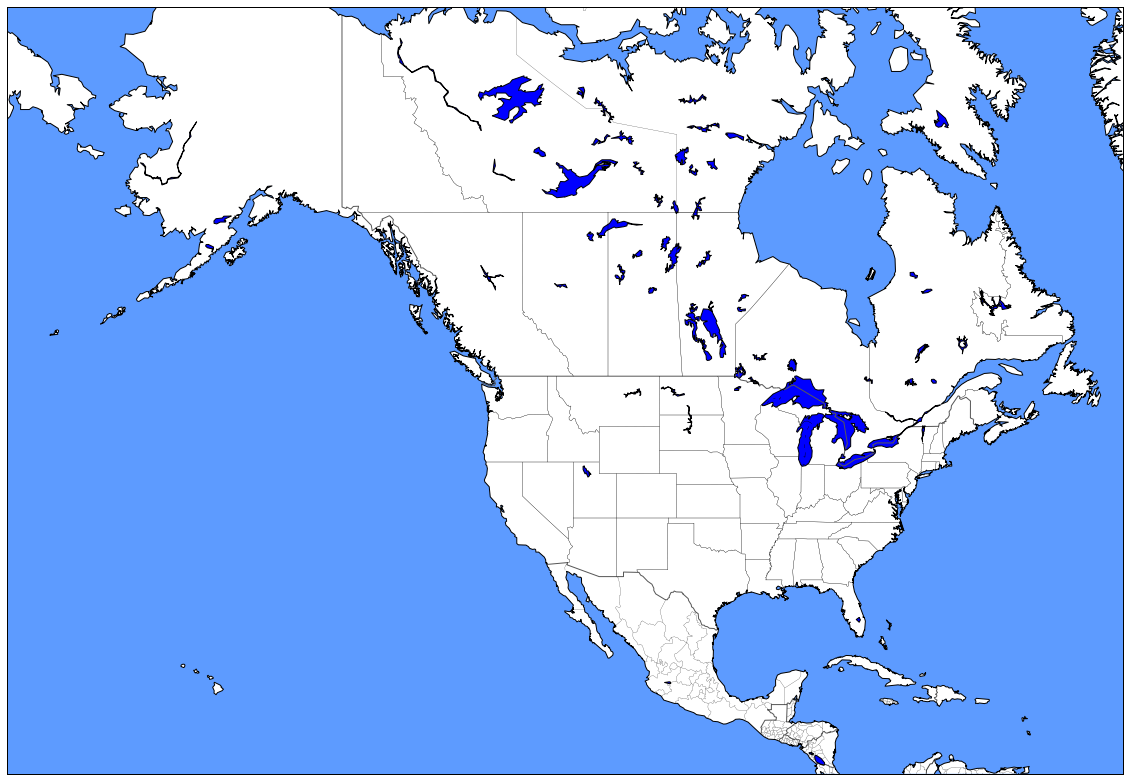

In [62]:
plt.figure(figsize = (20,20))
m = Basemap(projection='merc',llcrnrlon=-180,llcrnrlat=10,urcrnrlon=-50,
            urcrnrlat=70, lat_ts=0, resolution='l')
G = nx.Graph()
for w, c in rankedCorrelations:
    if w > 0.6:
        a, b = c
        G.add_edge(a.upper(), b.upper(), weight=w)
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 0.7]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] <= 0.7]
# pos = nx.spring_layout(G)

Points = {k:(long_lats[k]['latitude'], long_lats[k]['latitude']) for k in long_lats}
places = [key for key in Points]
Lon = [Points[key][0] for key in Points]
Lat = [Points[key][1] for key in Points]
X, Y = m(Lat,Lon)
pos = {places[i]:(X[i], Y[i]) for i in range(len(places))}

m.drawmapboundary(fill_color='#5D9BFF')
m.fillcontinents(color='white',lake_color='blue', zorder=0.5)
m.drawcountries(color='#585858',linewidth=1)
m.drawstates(linewidth = 0.2)
m.drawcoastlines()

nx.draw_networkx_nodes(G, pos, node_size=500, node_color='red')
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=5, edge_color='r')
nx.draw_networkx_labels(G, pos, font_size=5, font_family='sans-serif')

# nx.draw_networkx_nodes(G, pos, node_size=500)
# nx.draw_networkx_edges(G, pos, edgelist=elarge, width=5)
# nx.draw_networkx_edges(G, pos, edgelist=esmall,
#                        width=5, alpha=0.5, edge_color='b', style='dashed')
# nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
# plt.axis('off')
plt.show()

In [ ]:
Points = {k:(long_lats[k]['latitude'], long_lats[k]['latitude']) for k in long_lats}
places = [key for key in Points]
Lon = [Points[key][0] for key in Points]
Lat = [Points[key][1] for key in Points]
X, Y = m(Lat,Lon)
pos = {places[i]:(X[i], Y[i]) for i in range(len(places))}

m.drawmapboundary(fill_color='#5D9BFF')
m.fillcontinents(color='white',lake_color='blue', zorder=0.5)
m.drawcountries(color='#585858',linewidth=1)
m.drawstates(linewidth = 0.2)
m.drawcoastlines()

nx.draw_networkx_nodes(G, pos, node_size=500, node_color='red')
nx.draw_networkx_edges(G, pos, edgelist=edges, width=5, edge_color='r')
nx.draw_networkx_labels(G, pos, font_size=5, font_family='sans-serif')

{'AL': (32.38012, 32.38012), 'AK': (58.29974, 58.29974), 'AZ': (33.44826, 33.44826), 'AR': (34.748655, 34.748655), 'CA': (38.579065, 38.579065), 'CO': (39.74001, 39.74001), 'CT': (41.763325, 41.763325), 'DE': (39.158035, 39.158035), 'FL': (30.439775, 30.439775), 'GA': (33.748315000000005, 33.748315000000005), 'HI': (21.30477, 21.30477), 'ID': (43.60698, 43.60698), 'IL': (39.801055, 39.801055), 'IN': (39.766909999999996, 39.766909999999996), 'IA': (41.58979, 41.58979), 'KS': (39.049285, 39.049285), 'KY': (38.19507, 38.19507), 'LA': (30.443345, 30.443345), 'ME': (44.318036, 44.318036), 'MD': (38.9767, 38.9767), 'MA': (42.358635, 42.358635), 'MI': (42.73194, 42.73194), 'MN': (44.943829, 44.943829), 'MS': (32.29869, 32.29869), 'MO': (38.577515000000005, 38.577515000000005), 'MT': (46.58976, 46.58976), 'NE': (40.81362, 40.81362), 'NV': (39.164885, 39.164885), 'NH': (43.20725, 43.20725), 'NJ': (40.217875, 40.217875), 'NM': (35.691542999999996, 35.691542999999996), 'NY': (42.651445, 42.651445

From this Graph, we can see how the correlations naturally form these clusters of states with similar plants. States naturally cluster themselves by location.

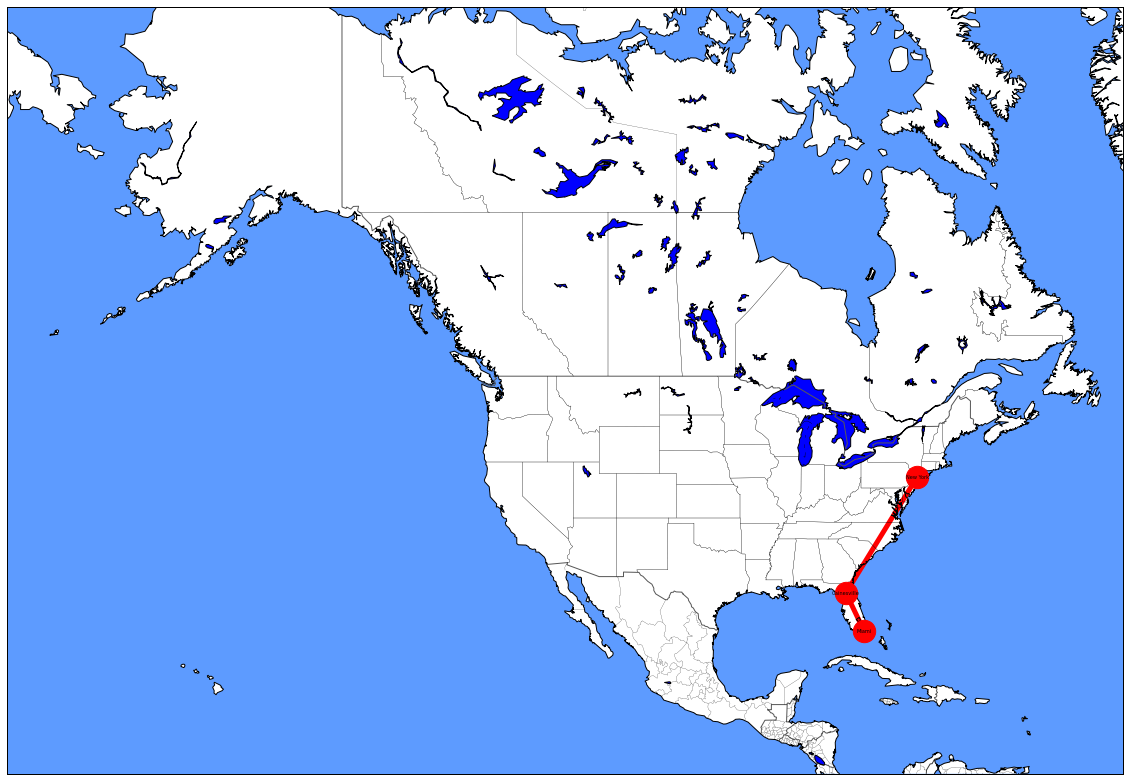

In [61]:
plt.figure(figsize = (20,20))
m = Basemap(projection='merc',llcrnrlon=-180,llcrnrlat=10,urcrnrlon=-50,
            urcrnrlat=70, lat_ts=0, resolution='l')

Points = {
    "New York":(40.7,-74),
    "Gainesville":(29.7,-82.3),
    "Miami":(25.8, -80.2)}
Lon = [Points[key][0] for key in Points]
Lat = [Points[key][1] for key in Points]
X, Y = m(Lat,Lon)

G = nx.Graph()
pos = {}
G.add_edge('New York', 'Gainesville')
G.add_edge('Gainesville', 'Miami')
pos['New York'] = (X[0], Y[0])
pos['Gainesville'] = (X[1], Y[1])
pos['Miami'] = (X[2], Y[2])

edges = [(u, v) for (u, v, d) in G.edges(data=True)]

m.drawmapboundary(fill_color='#5D9BFF')
m.fillcontinents(color='white',lake_color='blue', zorder=0.5)
m.drawcountries(color='#585858',linewidth=1)
m.drawstates(linewidth = 0.2)
m.drawcoastlines()

# nx.draw_networkx(G,pos,node_size=200,node_color='blue')
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='red')
nx.draw_networkx_edges(G, pos, edgelist=edges, width=5, edge_color='r')
nx.draw_networkx_labels(G, pos, font_size=5, font_family='sans-serif')

plt.show()

# Clustering

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [ ]:
def dfCol2List(dfCol):
    return dfCol.rdd.flatMap(lambda x: x).collect()

In [ ]:
for k in range(2, 20):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(dfVectors)
    predictions = model.transform(dfVectors)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    print("K: ", k)
    print("Silhouette with squared euclidean distance = " + str(silhouette))

Let's look closer at the K's with the top 7 Sillouette scores.

# Evaluation

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import pdb

kValues = [2, 3, 6, 7, 8, 9, 18]
for n_clusters in kValues:
    fig, ax = plt.subplots(1, 1)
    ax.set_xlim([0, 1])
    X = dfCol2List(dfVectors.select("features"))
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    kmeans = KMeans().setK(n_clusters).setSeed(1)
    model = kmeans.fit(dfVectors)
    predictions = model.transform(dfVectors)
    cluster_labels = np.array(dfCol2List(predictions.select("prediction")))
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        # pdb.set_trace()
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()